# Premier modele (V1)

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

## Chargement des données 

In [152]:
df = pd.read_csv('archive/Loan.csv',)
print(df.head())


  ApplicationDate  Age  AnnualIncome  CreditScore EmploymentStatus  \
0      2018-01-01   45         39948          617         Employed   
1      2018-01-02   38         39709          628         Employed   
2      2018-01-03   47         40724          570         Employed   
3      2018-01-04   58         69084          545         Employed   
4      2018-01-05   37        103264          594         Employed   

  EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  ...  \
0         Master          22       13152            48       Married  ...   
1      Associate          15       26045            48        Single  ...   
2       Bachelor          26       17627            36       Married  ...   
3    High School          34       37898            96        Single  ...   
4      Associate          17        9184            36       Married  ...   

   MonthlyIncome UtilityBillsPaymentHistory  JobTenure  NetWorth  \
0    3329.000000                   0.724972     

## Nettoyage des données 

In [153]:
df1 = df
df1['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
df1.dtypes

ApplicationDate               datetime64[ns]
Age                                    int64
AnnualIncome                           int64
CreditScore                            int64
EmploymentStatus                      object
EducationLevel                        object
Experience                             int64
LoanAmount                             int64
LoanDuration                           int64
MaritalStatus                         object
NumberOfDependents                     int64
HomeOwnershipStatus                   object
MonthlyDebtPayments                    int64
CreditCardUtilizationRate            float64
NumberOfOpenCreditLines                int64
NumberOfCreditInquiries                int64
DebtToIncomeRatio                    float64
BankruptcyHistory                      int64
LoanPurpose                           object
PreviousLoanDefaults                   int64
PaymentHistory                         int64
LengthOfCreditHistory                  int64
SavingsAcc

### Suppression des colonnes que l'on trouve pas pertinentes

In [154]:
colonnes_a_supprimer = [
    'ApplicationDate', 
    'LoanPurpose', 
    'EducationLevel', 
    'TotalAssets', 
    'TotalLiabilities', 
    'MonthlyIncome', 
    'UtilityBillsPaymentHistory', 
    'JobTenure'
]

df1 = df1.drop(columns=colonnes_a_supprimer, errors='ignore')

print(df1.head())


   Age  AnnualIncome  CreditScore EmploymentStatus  Experience  LoanAmount  \
0   45         39948          617         Employed          22       13152   
1   38         39709          628         Employed          15       26045   
2   47         40724          570         Employed          26       17627   
3   58         69084          545         Employed          34       37898   
4   37        103264          594         Employed          17        9184   

   LoanDuration MaritalStatus  NumberOfDependents HomeOwnershipStatus  ...  \
0            48       Married                   2                 Own  ...   
1            48        Single                   1            Mortgage  ...   
2            36       Married                   2                Rent  ...   
3            96        Single                   1            Mortgage  ...   
4            36       Married                   1            Mortgage  ...   

   LengthOfCreditHistory  SavingsAccountBalance  CheckingAccou

### Changement du type de valeur pour employmentStatus

In [155]:
df1.EmploymentStatus.value_counts()
df1['EmploymentStatus'] = df1['EmploymentStatus'].astype('category')
df1['EmploymentStatus'].head()

0    Employed
1    Employed
2    Employed
3    Employed
4    Employed
Name: EmploymentStatus, dtype: category
Categories (3, object): ['Employed', 'Self-Employed', 'Unemployed']

<Axes: xlabel='AnnualIncome', ylabel='LoanAmount'>

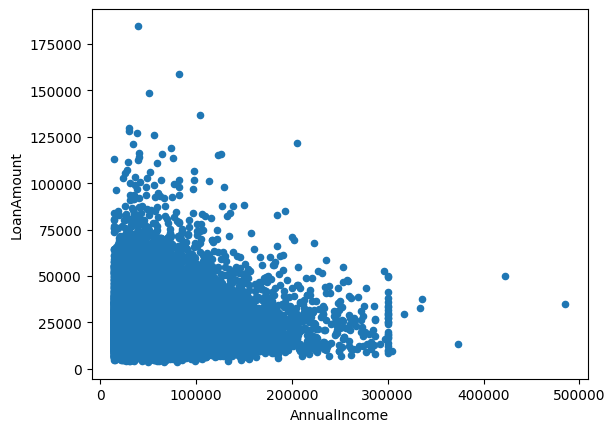

In [156]:
colonnes_utiles = [
    'Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus', 
    'LoanAmount', 'LoanDuration', 'DebtToIncomeRatio', 
    'PreviousLoanDefaults', 'PaymentHistory', 'InterestRate', 
    'LoanApproved', 'RiskScore'
]

# Ne conserver que les colonnes utiles dans le DataFrame
df1_reduit = df[colonnes_utiles]

# Vérifier les premières lignes du DataFrame réduit
df1_reduit.head()

df1_reduit.plot.scatter(x='AnnualIncome', y='LoanAmount')

### afficher avec un graphique en barre du taux d'accord de pret selon le EmploymentStatus

Text(0, 0.5, "Taux d'accord de prêt")

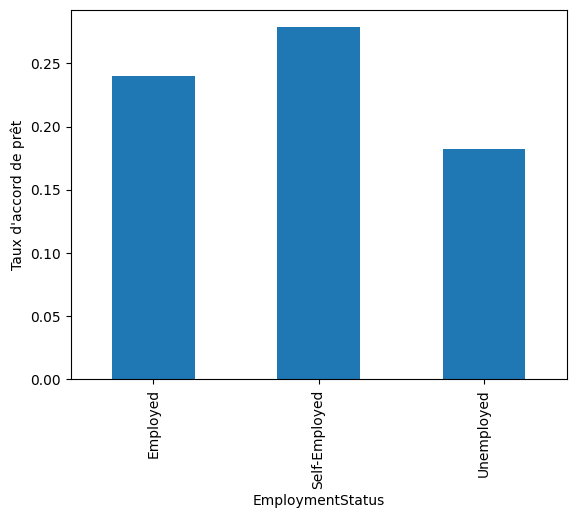

In [157]:
df1_reduit.groupby('EmploymentStatus')['LoanApproved'].mean().plot(kind='bar')
plt.ylabel('Taux d\'accord de prêt')


## Tester le modele

### Verification des valeurs manquantes

In [158]:
df1_reduit.isnull().sum()

Age                     0
AnnualIncome            0
CreditScore             0
EmploymentStatus        0
LoanAmount              0
LoanDuration            0
DebtToIncomeRatio       0
PreviousLoanDefaults    0
PaymentHistory          0
InterestRate            0
LoanApproved            0
RiskScore               0
dtype: int64

### Séparer les caractéristiques (X) et la variable cible (y)

In [159]:
X = df1_reduit.drop(['LoanApproved', 'RiskScore'], axis=1)  # Ici on utilise LoanApproved comme cible pour la classification
y = df1_reduit['LoanApproved']

### Encodage des variables catégorielles et normalisation
#### Identifier les colonnes numériques et catégorielles

In [160]:
colonnes_numeriques = ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'DebtToIncomeRatio', 'PreviousLoanDefaults', 'PaymentHistory', 'InterestRate']
colonnes_categoriques = ['EmploymentStatus']

### Séparation des données en train et test

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Créer un pipeline de prétraitement

In [162]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colonnes_numeriques),
        ('cat', OneHotEncoder(), colonnes_categoriques)
    ])

### Créer un pipeline complet

In [163]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

## Entrainer le modele

In [164]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'AnnualIncome',
                                                   'CreditScore', 'LoanAmount',
                                                   'LoanDuration',
                                                   'DebtToIncomeRatio',
                                                   'PreviousLoanDefaults',
                                                   'PaymentHistory',
                                                   'InterestRate']),
                                                 ('cat', OneHotEncoder(),
                                                  ['EmploymentStatus'])])),
                ('classifier', RandomForestClassifier())])

### Faire des prédictions et évaluer le modèle

In [165]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.91


### Le probleme avec ce modele etait qu'il nous repondait TOUJOURS Oui, meme avec des valeurs absurdes, nous avons donc decidé de changer notre approche sur le dataset 

# Deuxieme modele (V1.5)

## Separation des données en deux groupes (prêts approuvés et non approvués)

In [166]:
df_approved = df[df.LoanApproved == 1]
df_not_approved = df[df.LoanApproved == 0]

### Création d'un echantillon equilibré pour l'netrainement du modele

In [167]:
df_sample = pd.concat([df_approved.sample(1478), df_not_approved.sample(2000)])

### Afficher les statistiques descriptives pour avoir un aperçu des données

In [168]:
print(df_sample.describe())

                     ApplicationDate          Age   AnnualIncome  CreditScore  \
count                           3478  3478.000000    3478.000000  3478.000000   
mean   2045-06-12 12:59:12.386428928    40.638010   70303.844451   573.289247   
min              2018-01-04 00:00:00    18.000000   15000.000000   380.000000   
25%              2031-10-23 18:00:00    32.000000   36915.250000   541.000000   
50%              2045-06-04 12:00:00    41.000000   58385.500000   580.000000   
75%              2059-03-30 18:00:00    49.000000   90094.250000   611.000000   
max              2072-10-03 00:00:00    80.000000  485341.000000   702.000000   
std                              NaN    11.675426   46705.957117    51.292675   

        Experience     LoanAmount  LoanDuration  NumberOfDependents  \
count  3478.000000    3478.000000   3478.000000         3478.000000   
mean     18.393617   23458.268833     52.357677            1.539390   
min       0.000000    3729.000000     12.000000          

## Visualisation des relations entre les variables

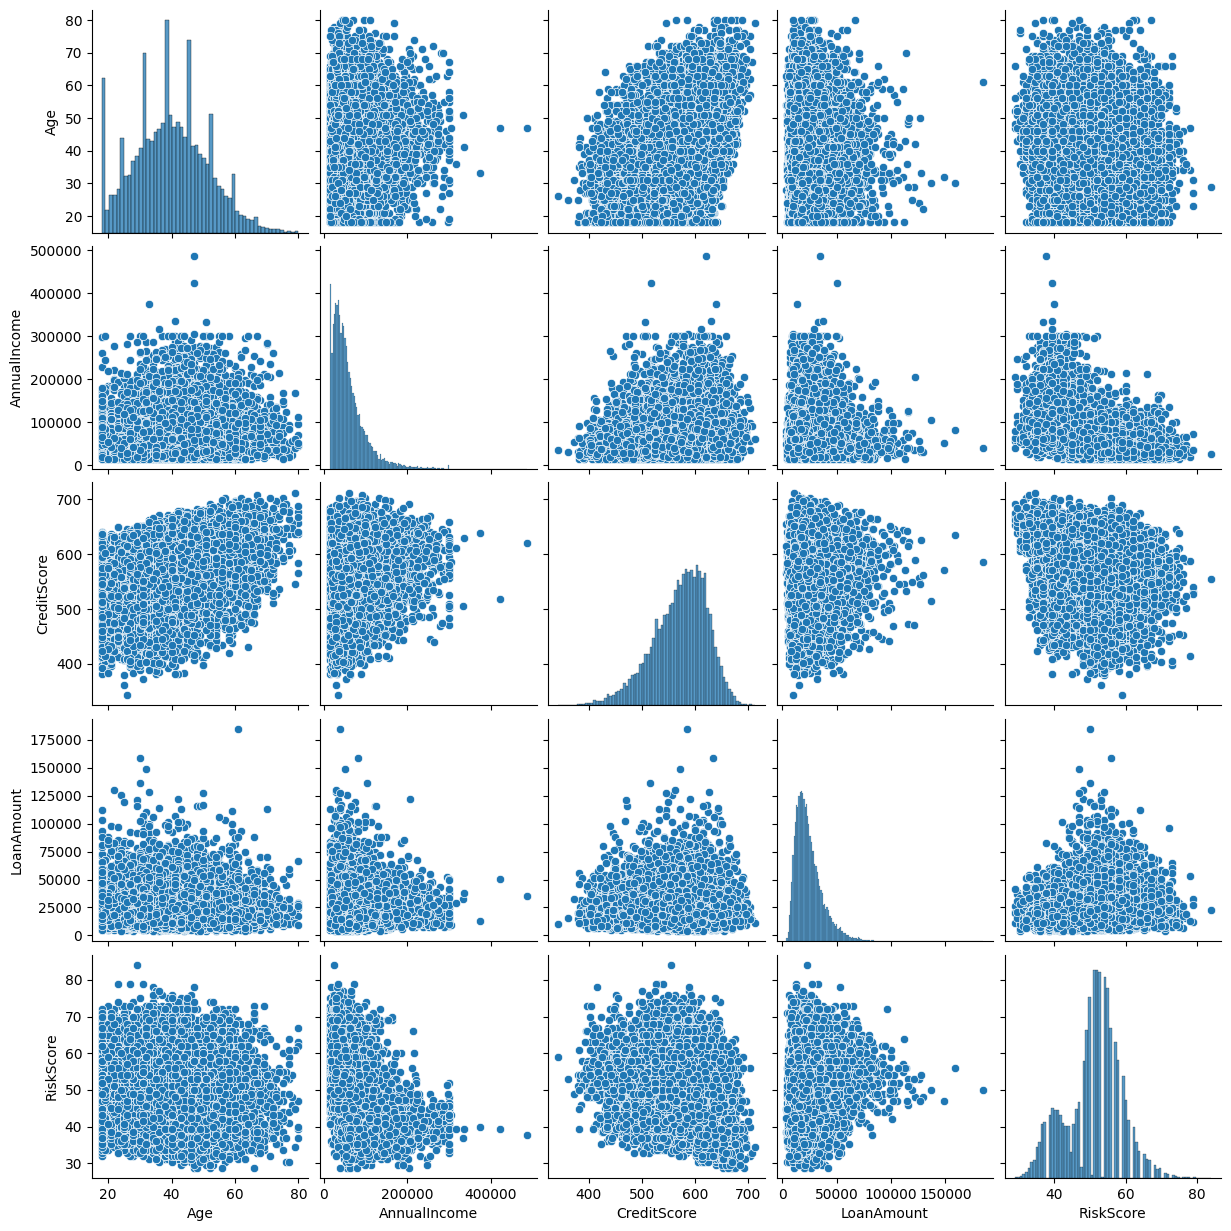

In [169]:
sns.pairplot(df[['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'RiskScore']])
plt.show()

### Compter le nombre de prets approuvés et non approuvés dans l'echantillon

In [170]:
print(df_sample['LoanApproved'].value_counts())
print(df_sample['LoanApproved'].value_counts(normalize=True))


LoanApproved
0    2000
1    1478
Name: count, dtype: int64
LoanApproved
0    0.575043
1    0.424957
Name: proportion, dtype: float64


## Sélectionner les colonnes pertinentes pour l'analyse et le modèle

In [171]:
cols_to_keep = ['Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus', 'LoanAmount', 'LoanDuration', 
                'DebtToIncomeRatio', 'PreviousLoanDefaults', 'PaymentHistory', 'HomeOwnershipStatus', 
                'MaritalStatus', 'MonthlyDebtPayments']

df_filtered = df_sample[cols_to_keep]

### Encoder les variables catégorielles (transformer en variables numériques)

In [172]:
df_encoded = pd.get_dummies(df_filtered, columns=['EmploymentStatus', 'HomeOwnershipStatus', 'MaritalStatus'], drop_first=True)

print(df_encoded.head())


       Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
19620   60         61595          560       19719            36   
16940   37        150576          593       12011            72   
10079   27         83046          517       22327            60   
22      40        114216          635        9809            60   
9165    39         47140          577        8009            12   

       DebtToIncomeRatio  PreviousLoanDefaults  PaymentHistory  \
19620           0.275446                     0              18   
16940           0.611985                     0              24   
10079           0.515821                     0              21   
22              0.630448                     0              26   
9165            0.484214                     0              20   

       MonthlyDebtPayments  EmploymentStatus_Self-Employed  \
19620                  170                           False   
16940                  487                           False   
10079         

### Colonnes à normaliser pour que toutes soient sur la même échelle (entre 0 et 1)

In [173]:
cols_to_scale = ['AnnualIncome', 'LoanAmount', 'DebtToIncomeRatio', 'MonthlyDebtPayments', 'CreditScore']

scaler = MinMaxScaler()
df_encoded[cols_to_scale] = scaler.fit_transform(df_encoded[cols_to_scale])
print(df_encoded[cols_to_scale].head())

       AnnualIncome  LoanAmount  DebtToIncomeRatio  MonthlyDebtPayments  \
19620      0.099066    0.135448           0.319281             0.047743   
16940      0.288250    0.070155           0.715943             0.212247   
10079      0.144674    0.157539           0.602599             0.128697   
22         0.210945    0.051502           0.737704             0.255838   
9165       0.068333    0.036255           0.565346             0.259990   

       CreditScore  
19620     0.559006  
16940     0.661491  
10079     0.425466  
22        0.791925  
9165      0.611801  


## Entrainement

### Définir les variables explicatives (X) et la variable cible (y)

In [174]:
X = df_encoded
y = df_sample['LoanApproved']

### Diviser le dataset en données d'entraînement (80%) et de test (20%)

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Créer un classifieur Random Forest

In [176]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_features=2)

In [177]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=2, random_state=42)

### Faire des prédictions sur les données de test

In [178]:
y_pred = rf.predict(X_test)

## Calculer l'accuracy (précision) du modèle

In [179]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8505747126436781


### Visualiser l'importance des différentes caractéristiques (features)

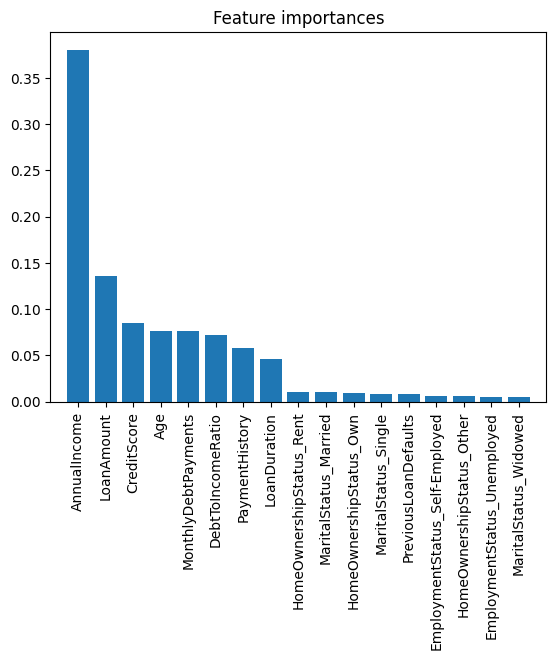

In [180]:
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


### Afficher la distribution du statut d'occupation de logement par rapport à l'approbation du prêt

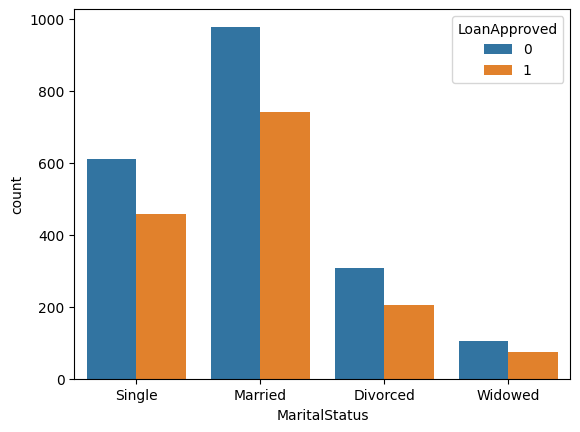

In [181]:
sns.countplot(x='MaritalStatus', hue='LoanApproved', data=df_sample)
plt.show()

### Matrice de confusion pour évaluer les performances du modèle


In [182]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


[[340  41]
 [ 63 252]]


## Rapport de classification (précision, rappel, F1-score)

In [183]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       381
           1       0.86      0.80      0.83       315

    accuracy                           0.85       696
   macro avg       0.85      0.85      0.85       696
weighted avg       0.85      0.85      0.85       696



## Creation du regresseur sur RiskScore

In [184]:
regressor = RandomForestRegressor(random_state=42)

### Diviser les données pour la régression

In [185]:
X_reg = df_encoded
y_reg = df_sample['RiskScore']

In [186]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

### Entraîner le modèle de régression

In [187]:
regressor.fit(X_train_reg, y_train_reg)

RandomForestRegressor(random_state=42)

### Faire des prédictions sur les données de test

In [188]:
y_pred_reg = regressor.predict(X_test_reg)

### Calculer l'erreur absolue moyenne

In [189]:
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 4.228663793103447


# Troisieme Modele (V2)

In [195]:
colonnes_utiles = [
    'Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus',
    'LoanAmount', 'LoanDuration', 'DebtToIncomeRatio',
    'PreviousLoanDefaults',
    'LoanApproved', 'RiskScore'
]
df = df[colonnes_utiles]

In [196]:
dfYes = df[df['LoanApproved'] == 1]
dfNo = df[df['LoanApproved'] == 0]

dfSample = pd.concat([dfYes.sample(1478), dfNo.sample(2000)])
dfSample = pd.get_dummies(dfSample, columns=['EmploymentStatus'])


## Visualisation des données

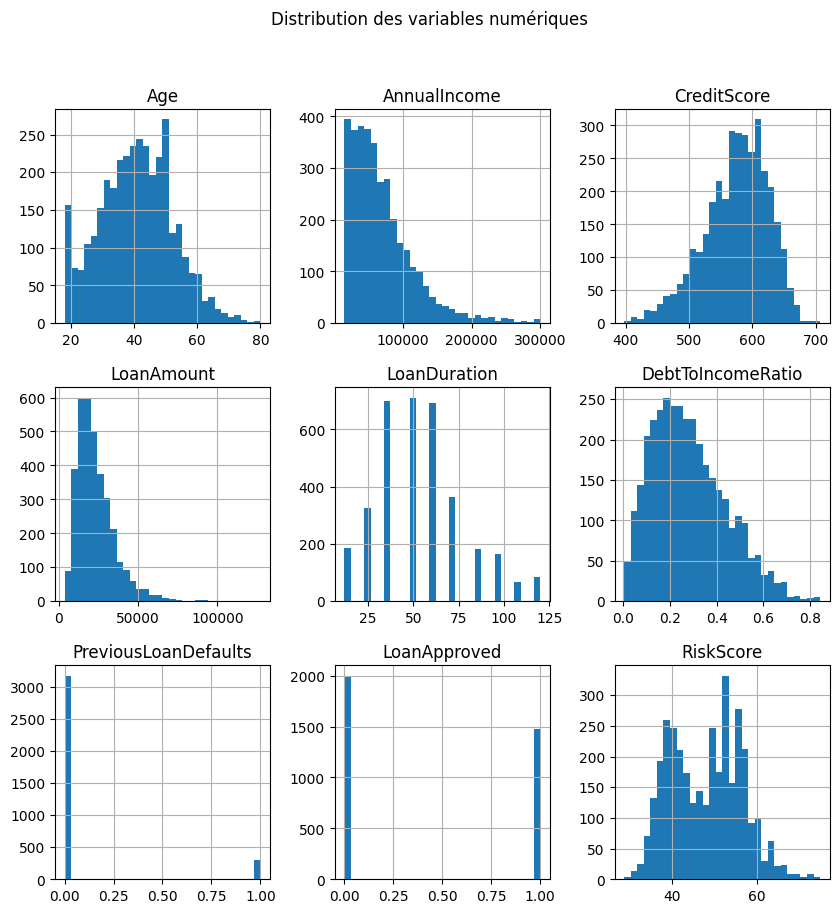

In [197]:
dfSample.hist(bins=30,figsize=(10,10))
plt.suptitle('Distribution des variables numériques')
plt.show()

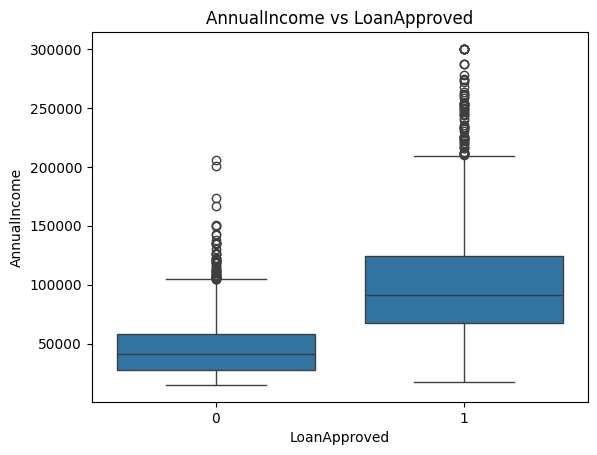

In [198]:
sns.boxplot(x='LoanApproved', y='AnnualIncome', data=dfSample)
plt.title('AnnualIncome vs LoanApproved')
plt.show()

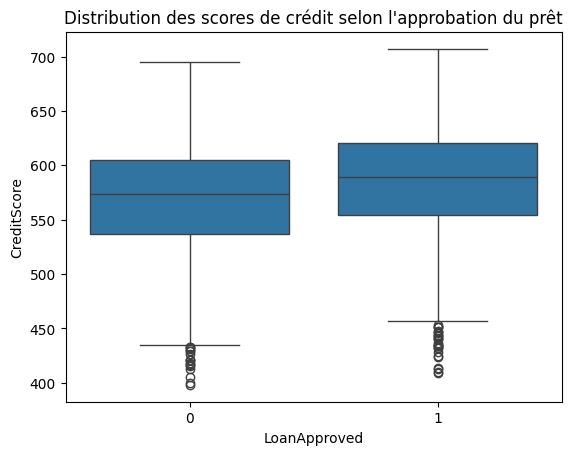

In [199]:
sns.boxplot(x='LoanApproved', y='CreditScore', data=dfSample)
plt.title('Distribution des scores de crédit selon l\'approbation du prêt')
plt.show()

## On peut déjà observer plusieurs corrélations importantes, comme la corrélation positive entre `CreditScore` et `LoanApproved`.


### Corrélation entre les variables

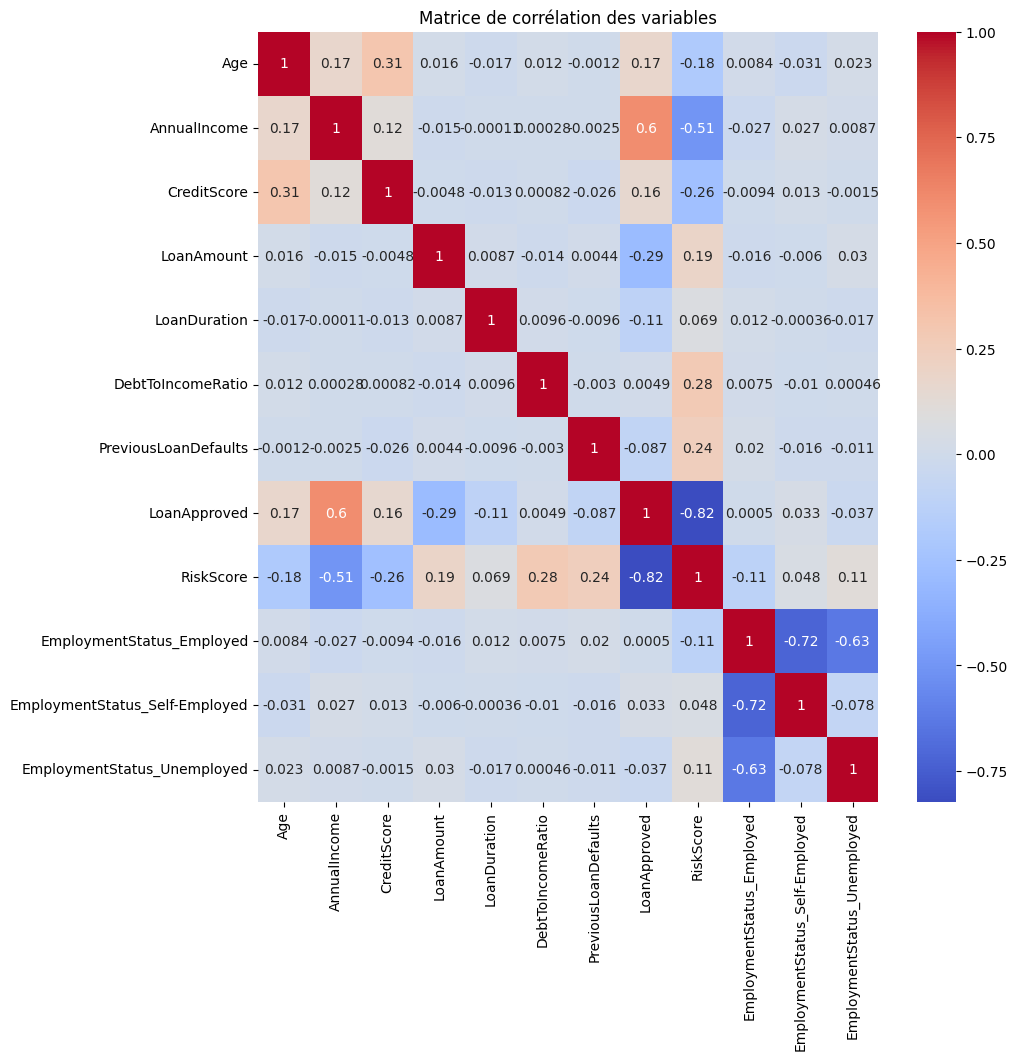

In [200]:
plt.figure(figsize=(10, 10))
sns.heatmap(dfSample.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation des variables")
plt.show()

## Création des ranges pour certaines variables

In [201]:
age_bins = [18, 25, 35, 45, 55, 65, 100]
age_labels = ['18-25', '25-35', '35-45', '45-55', '55-65', '65+']
dfSample['AgeRange'] = pd.cut(dfSample['Age'], bins=age_bins, labels=age_labels)

In [202]:
loan_bins = [0, 5000, 10000, 20000, 50000, 100000, 500000]
loan_labels = ['0-5K', '5K-10K', '10K-20K', '20K-50K', '50K-100K', '100K+']
dfSample['LoanAmountRange'] = pd.cut(dfSample['LoanAmount'], bins=loan_bins, labels=loan_labels)

In [203]:
credit_bins = [300, 500, 600, 700, 800, 900, 1000]
credit_labels = ['300-500', '500-600', '600-700', '700-800', '800-900', '900+']
dfSample['CreditScoreRange'] = pd.cut(dfSample['CreditScore'], bins=credit_bins, labels=credit_labels)

### Visualisation des données avec les ranges

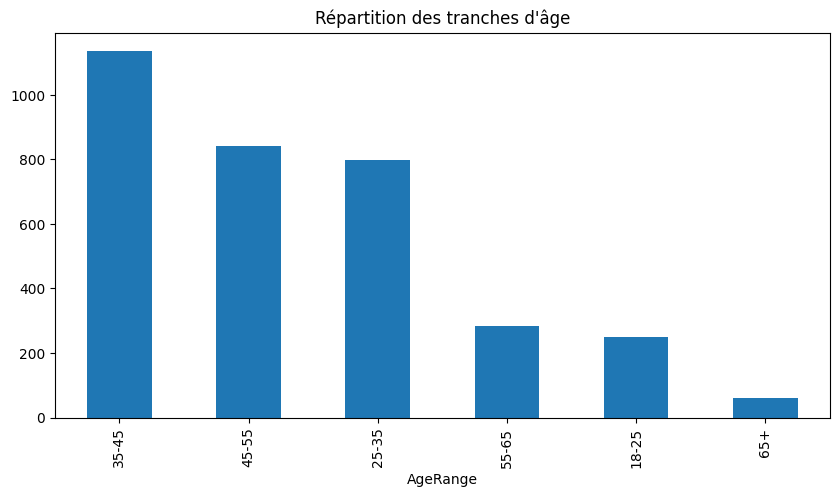

In [204]:
dfSample['AgeRange'].value_counts().plot(kind='bar', figsize=(10, 5), title='Répartition des tranches d\'âge')
plt.show()

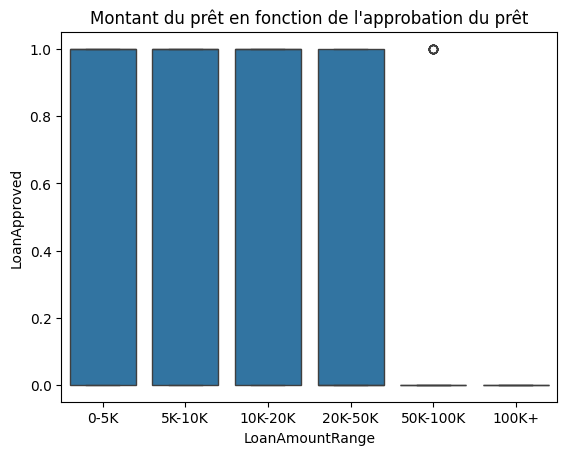

In [206]:
sns.boxplot(x='LoanAmountRange', y='LoanApproved', data=dfSample)
plt.title('Montant du prêt en fonction de l\'approbation du prêt')
plt.show()

## Préparation des données pour l'entraînement

In [207]:
X = pd.get_dummies(dfSample.drop(['LoanApproved', 'RiskScore'], axis=1))
y = dfSample['LoanApproved']

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [209]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [210]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train_scaled, y_train)

GaussianNB()

In [211]:
y_pred = classifier.predict(X_test_scaled)

In [212]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy avec les ranges et données normalisées: {accuracy}")

Accuracy avec les ranges et données normalisées: 0.7600574712643678


### Matrice de confusion

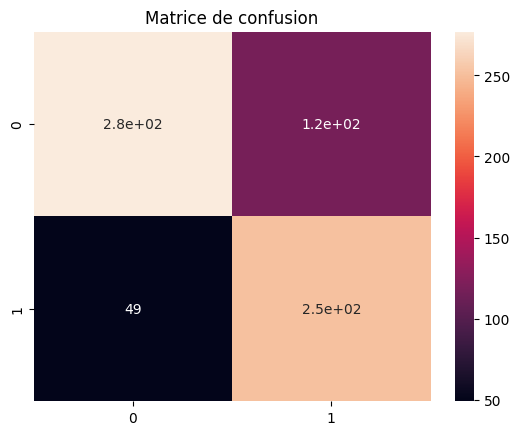

In [214]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.title('Matrice de confusion')
plt.show()

# Dernier modele (V3)

In [216]:
donnees = pd.read_csv('./archive/Loan.csv')
donnees.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


## Suppression des colonnes non nécessaires

In [217]:
donnees = donnees.drop(['ApplicationDate', 'MaritalStatus', 'LoanPurpose', 'EducationLevel', 'AnnualIncome'], axis=1)

### Corrélation avec LoanApproved

In [218]:
num_cols = donnees.select_dtypes(include='number').columns
correlations_loanapproved = {}
for col in num_cols:
    if col != 'RiskScore':
        corr, p_value = pointbiserialr(donnees['LoanApproved'], donnees[col])
        correlations_loanapproved[col] = {'correlation': corr, 'p_value': p_value}

print("Corrélations avec LoanApproved:")
print(pd.DataFrame(correlations_loanapproved).T)

Corrélations avec LoanApproved:
                            correlation        p_value
Age                            0.141029   2.302532e-89
CreditScore                    0.142000   1.381666e-90
Experience                     0.140755   5.062367e-89
LoanAmount                    -0.239496  7.325162e-259
LoanDuration                  -0.094558   5.904813e-41
NumberOfDependents             0.001717   8.081220e-01
MonthlyDebtPayments           -0.070415   2.064320e-23
CreditCardUtilizationRate     -0.010466   1.388570e-01
NumberOfOpenCreditLines       -0.004769   5.000995e-01
NumberOfCreditInquiries       -0.005885   4.052876e-01
DebtToIncomeRatio              0.000034   9.961342e-01
BankruptcyHistory             -0.070751   1.275268e-23
PreviousLoanDefaults          -0.065343   2.240870e-20
PaymentHistory                 0.030804   1.317633e-05
LengthOfCreditHistory          0.105949   5.045309e-51
SavingsAccountBalance          0.000961   8.918803e-01
CheckingAccountBalance         0.

In [219]:
correlations_riskscore = {}
for col in num_cols:
    if col != 'LoanApproved':
        corr, p_value = pearsonr(donnees['RiskScore'], donnees[col])
        correlations_riskscore[col] = {'correlation': corr, 'p_value': p_value}

print("Corrélations avec RiskScore:")
print(pd.DataFrame(correlations_riskscore).T)

Corrélations avec RiskScore:
                            correlation        p_value
Age                           -0.164304  4.943609e-121
CreditScore                   -0.240198  2.044732e-260
Experience                    -0.166496  2.819581e-124
LoanAmount                     0.137981   1.373319e-85
LoanDuration                   0.054550   1.164751e-14
NumberOfDependents             0.001686   8.115018e-01
MonthlyDebtPayments            0.036938   1.738976e-07
CreditCardUtilizationRate      0.108758   1.101824e-53
NumberOfOpenCreditLines        0.007762   2.723508e-01
NumberOfCreditInquiries        0.003103   6.608393e-01
DebtToIncomeRatio              0.326500   0.000000e+00
BankruptcyHistory              0.377578   0.000000e+00
PreviousLoanDefaults           0.258659  4.267532e-303
PaymentHistory                -0.016992   1.626134e-02
LengthOfCreditHistory         -0.177796  1.028336e-141
SavingsAccountBalance          0.002190   7.567712e-01
CheckingAccountBalance        -0.004

#### Colonnes candidates à la suppression (LoanApproved)
- NumberOfDependents (corrélation = 0.0017)
- CreditCardUtilizationRate (corrélation = -0.010)
- NumberOfOpenCreditLines (corrélation = -0.0047)
- NumberOfCreditInquiries (corrélation = -0.0059)
- DebtToIncomeRatio (corrélation = 0.000034)
- SavingsAccountBalance (corrélation = 0.00096)
- CheckingAccountBalance (corrélation = 0.00066)
- UtilityBillsPaymentHistory (corrélation = 0.0033)
- JobTenure (corrélation = 0.0049)

#### Colonnes candidates à la suppression (RiskScore)
- NumberOfDependents : 0.0017
- NumberOfOpenCreditLines : 0.0077
- NumberOfCreditInquiries : 0.0031
- SavingsAccountBalance : 0.0022
- CheckingAccountBalance : -0.0040
- UtilityBillsPaymentHistory : -0.0052
- JobTenure : -0.0044

In [220]:
colonnes_a_supprimer = [
    'NumberOfDependents', 
    'NumberOfOpenCreditLines', 
    'NumberOfCreditInquiries', 
    'SavingsAccountBalance', 
    'CheckingAccountBalance', 
    'UtilityBillsPaymentHistory', 
    'JobTenure', 
    'CreditCardUtilizationRate', 
    'DebtToIncomeRatio'
]

df = donnees.drop(columns=colonnes_a_supprimer, axis=1)

In [221]:
label_encoder = LabelEncoder()

# Identifier toutes les colonnes catégorielles (non numériques)
colonnes_a_encoder = df.select_dtypes(include=['object', 'category']).columns

# Appliquer l'encodeur à chaque colonne
for col in colonnes_a_encoder:
    df[col] = label_encoder.fit_transform(df[col])

## Visualisation des Données

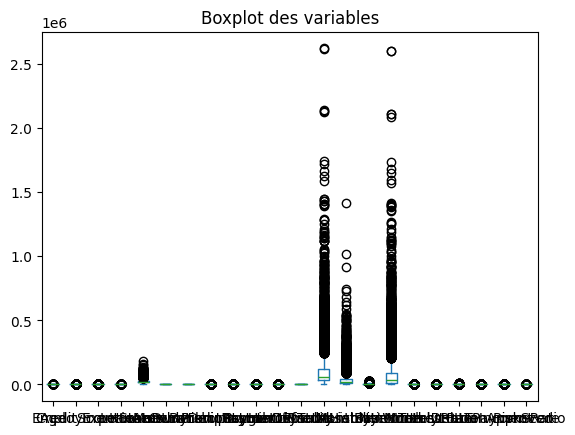

In [222]:
df.plot.box()
plt.title("Boxplot des variables")
plt.show()

## Réduction des Caractéristiques

In [223]:
correlation_matrix = df.corr()

# Étape 2 : Identifier les colonnes à supprimer
threshold = 0.8  # Seuil de corrélation
to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)


# Supprimer les colonnes identifiées
print("Colonnes à supprimer en raison d'une forte corrélation:", to_drop)
df_reduced = df.drop(columns=to_drop)

# Afficher les colonnes restantes
print("Colonnes après réduction :", df_reduced.columns.tolist())

Colonnes à supprimer en raison d'une forte corrélation: {'InterestRate', 'NetWorth', 'Experience'}
Colonnes après réduction : ['Age', 'CreditScore', 'EmploymentStatus', 'LoanAmount', 'LoanDuration', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'BaseInterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore']


## Modelisation

In [224]:
X = df_reduced.drop(['LoanApproved', 'RiskScore'], axis=1)  # Caractéristiques
y_classification = df_reduced['LoanApproved']  # Variable cible pour la classification
y_regression = df_reduced['RiskScore']  # Variable cible pour la régression

In [225]:
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.2, random_state=42)
_, _, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)

In [226]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train_class)

DecisionTreeClassifier(random_state=42)

In [227]:
y_pred_class = dt_classifier.predict(X_test)

In [228]:
accuracy = accuracy_score(y_test_class, y_pred_class)
print("Accuracy (Classification):", accuracy)

Accuracy (Classification): 0.871


### Visualisation de l'Importance des Caractéristiques

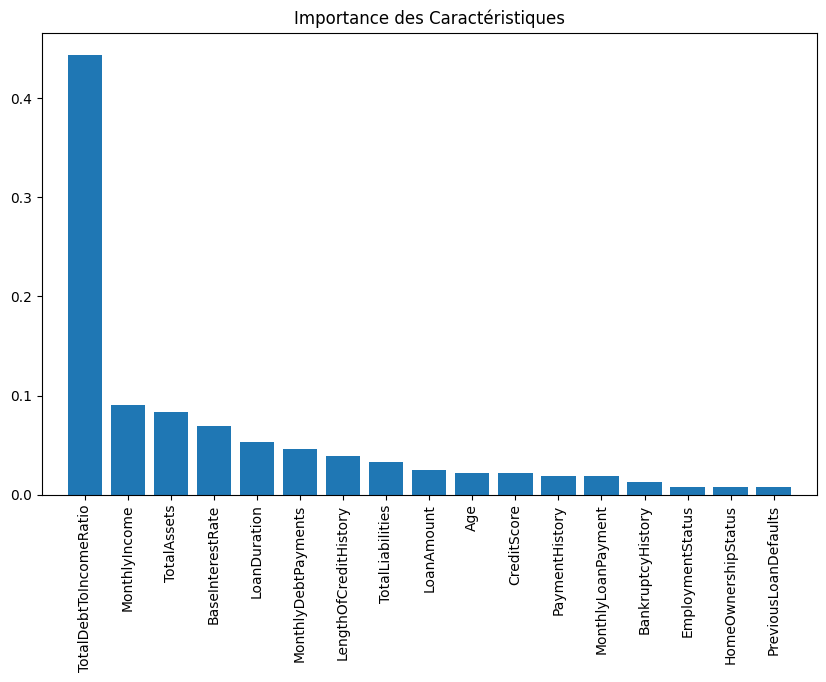

In [230]:
feature_importances = dt_classifier.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importance des Caractéristiques")
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### Créer et entraîner l'arbre de décision pour la régression

In [231]:
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train_reg)

DecisionTreeRegressor(random_state=42)

In [232]:
y_pred_reg = dt_regressor.predict(X_test)

In [233]:
mse = mean_squared_error(y_test_reg, y_pred_reg)
print("(Regression):", mse)

(Regression): 33.01521999999999
